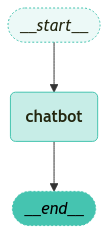

In [1]:
from dotenv import load_dotenv
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

load_dotenv()

class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
    

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [2]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 서울에는 다양한 맛집이 많아서 선택하기가 어렵지만, 다음은 서울에서 유명한 맛집 TOP 10을 추천해 드립니다. 각 식당은 고유의 매력을 가지고 있으니 참고해 보세요!

1. **광장시장** - 전통 시장으로, 빈대떡, 마약김밥, 떡볶이 등 다양한 길거리 음식을 즐길 수 있습니다.

2. **이태원 부대찌개** - 부대찌개로 유명한 이곳은 푸짐한 양과 깊은 맛으로 많은 사랑을 받고 있습니다.

3. **명동교자** - 칼국수와 만두가 유명한 곳으로, 항상 많은 사람들이 줄 서서 기다리는 인기 맛집입니다.

4. **삼청동 수제비** - 수제비와 전통 한식을 즐길 수 있는 아늑한 분위기의 식당입니다.

5. **한남동 고기리 막창** - 막창과 다양한 고기 요리를 전문으로 하는 곳으로, 고기의 질이 뛰어납니다.

6. **신사동 가로수길의 카페 드 파리** - 디저트와 브런치로 유명한 카페로, 분위기가 좋고 인스타그램에 올리기 좋은 메뉴가 많습니다.

7. **종로의 통인시장** - 다양한 전통 음식을 한 곳에서 즐길 수 있는 시장으로, 특히 김밥과 떡볶이가 인기입니다.

8. **압구정의 미슐랭 가이드 선정 레스토랑** - 고급 한식을 제공하는 곳으로, 특별한 날에 가기 좋은 레스토랑입니다.

9. **홍대의 연남동 베이커리** - 다양한 빵과 디저트를 제공하는 베이커리로, 아침이나 간식으로 좋습니다.

10. **강남의 스시조** - 신선한 재료로 만든 스시를 즐길 수 있는 고급 스시집으로, 특별한 날에 추천합니다.

각 식당의 운영 시간이나 메뉴는 변동이 있을 수 있으니 방문 전에 확인해 보시는 것이 좋습니다. 맛있는 식사 되세요!


In [4]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

In [5]:
########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)

In [6]:
########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


In [7]:
########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########

# 메모리 저장소 초기화
memory = MemorySaver()

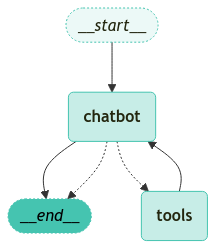

In [8]:
########## 6. interrupt_before 추가 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)
########## 7. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

In [9]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_dbTQy7lnoRBxO0oQlOgtDBbH)
 Call ID: call_dbTQy7lnoRBxO0oQlOgtDBbH
  Args:
    query: AI


In [10]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

In [11]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)

    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "call_dbTQy7lnoRBxO0oQlOgtDBbH"
        type: "tool_call"


In [12]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_dbTQy7lnoRBxO0oQlOgtDBbH)
 Call ID: call_dbTQy7lnoRBxO0oQlOgtDBbH
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE9PTTNKM2pLRXlvN3dzckxpeFJ3NFpRZU1mTTFxLVBXeGFpX0lISWY2MjNYV2E2cXdlZkFlRUw5S25SRldtN2dzUnczcElRZ2xIa3BEbDQ4dGc2Q182OW5wTU9nOTVhSld2eHc?oc=5", "content": "오픈AI, 미국서 AI 에이전트 '오퍼레이터' 출시...\"곧 다른 국가에서도 공개\" - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiXkFVX3lxTE5HaUJoVTJ0Q0JHSDhkQ0Z4VEJjdHhoWVZaRjdYTkVQMk8tblVlcTFOUFNNU19JX2xfbVA5TnYxeXZYRUlIWGVwZ1JpM202WlNSVk9vRE14eEJwYTZjd2fSAXZBVV95cUxNSzVORkZVY3E2Z1FQSkxNRW1tWVNydzZqa2o4NFJUWmxnV01aQ3ZQUGt3NzczeTZmOEtZMmhTaWV2VmExMGJ4Rm9HVlBSU1ZQN2xvc2NoVGQtVmFYNU92VS1BazRoNVpiTmpFd0ZfdXZBcmc4TUpB?oc=5", "content": "오픈AI, AI 에이전트 '오퍼레이터' 공개...예약·쇼핑 척척 - YTN"}, {"url": "https:/

In [13]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state

메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


In [14]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efda22a-9929-608b-8002-befdf3adc193'}}


In [15]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda22a-9929-608b-8002-befdf3adc193'}}

In [16]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE9PTTNKM2pLRXlvN3dzckxpeFJ3NFpRZU1mTTFxLVBXeGFpX0lISWY2MjNYV2E2cXdlZkFlRUw5S25SRldtN2dzUnczcElRZ2xIa3BEbDQ4dGc2Q182OW5wTU9nOTVhSld2eHc?oc=5", "content": "오픈AI, 미국서 AI 에이전트 '오퍼레이터' 출시...\"곧 다른 국가에서도 공개\" - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiXkFVX3lxTE5HaUJoVTJ0Q0JHSDhkQ0Z4VEJjdHhoWVZaRjdYTkVQMk8tblVlcTFOUFNNU19JX2xfbVA5TnYxeXZYRUlIWGVwZ1JpM202WlNSVk9vRE14eEJwYTZjd2fSAXZBVV95cUxNSzVORkZVY3E2Z1FQSkxNRW1tWVNydzZqa2o4NFJUWmxnV01aQ3ZQUGt3NzczeTZmOEtZMmhTaWV2VmExMGJ4Rm9HVlBSU1ZQN2xvc2NoVGQtVmFYNU92VS1BazRoNVpiTmpFd0ZfdXZBcmc4TUpB?oc=5", "content": "오픈AI, AI 에이전트 '오퍼레이터' 공개...예약·쇼핑 척척 - YTN"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1YWTRlTFpzX01xNTBIR1BzcE80SnRLYUtOZVZrd0hmRFJzU3B4N2VWeElySFJaZlJXREl1bEtwbGV2RU4zb2hzVHlpUkVyQk1RQ0o2Mi1jOFNROVnSAV5BVV95cUxPZHlkNmJOcnBaNjFWdFFPNWpLWmJGUGVjNk